# Data exploration

In [535]:
from pathlib import Path
import json

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()

In [532]:
# Read dataset

class Cfg:
    RANDOM_STATE = 2023
    INPUT_ROOT = Path('/home/gpu/Kaggle/GOOGLE-ASL/data/raw')
    OUTPUT_ROOT = Path('../data/preprocessed')
    INDEX_MAP_FILE = INPUT_ROOT / 'sign_to_prediction_index_map.json'
    TRAN_FILE = INPUT_ROOT / 'train.csv'
    INDEX = 'sequence_id'
    ROW_ID = 'row_id'

def read_train(file_path=Cfg.TRAN_FILE):
    """Reads the train csv as pandas data frame."""
    return pd.read_csv(file_path).set_index(Cfg.INDEX)

def read_landmark_data_by_path(file_path, input_root=Cfg.INPUT_ROOT):
    """Reads landmak data by the given file path."""
    data = pd.read_parquet(input_root / file_path)
    return data.set_index(Cfg.ROW_ID)

def read_index_map(file_path=Cfg.INDEX_MAP_FILE):
    """Reads the sign to predict as json file."""
    with open(file_path, "r") as f:
        result = json.load(f)
    return result


data = read_train()
data.head()

In [541]:
# Add labels

sign2idx_map = read_index_map()
data['label'] = data.sign.progress_apply(lambda s: sign2idx_map[s])

  0%|          | 0/94477 [00:00<?, ?it/s]

# Participants

There are a total of 21 different participants.

Each of them has signed a mean of 4499 sequences, with a maximum difference of 503 signed sequences between participants. It can be considered balanced in terms of signers.

In [23]:
# Number of participants

num_participants = len(data.participant_id.unique())
num_participants

21

In [25]:
# Distribution of participants per sequence

participant_value_counts = data.participant_id.value_counts()
participant_value_counts.min(), participant_value_counts.max(), participant_value_counts.mean(), participant_value_counts.std()

(3338, 4968, 4498.9047619047615, 502.8928220567385)

# Signs

There are 250 different signs.

In terms of samples per sign they are well balanced, with a mean of 377 samples per sign.

In [9]:
# Number of signs

num_signs = len(data.sign.unique())
num_signs

250

In [22]:
# Distribution of examples per sign

sing_value_counts = data.sign.value_counts()
sing_value_counts.min(), sing_value_counts.max(), sing_value_counts.values.mean(), sing_value_counts.values.std()

(299, 415, 377.908, 19.356537293638034)

# Sequences

There are a total of 94477 sequences.

They have a mean of 38 frames, being the maximum difference of 44 frames.

All sequences have pose and face. On the other hand, right and left hand are missing almost half of the time.

For those sequences that have either face or pose, those are present throught all frames. On the other hand, for left and right hand the bast majority have less than 5% of coordinates missing.

There is not an skew on which sings are performed with the right or left hand.

In [426]:
# Number of sequences

num_seqs = len(data)
num_seqs

94477

In [114]:
# Duration of sequences

def count_seq(path):
    return len(read_landmark_data_by_path(path).frame.unique())
    
# data['n_frames'] = data.path.progress_apply(count_seq) # Takes 26:46 mins to process
# data.to_csv('edata.csv')

data.n_frames.min(), data.n_frames.max(), data.n_frames.mean(), data.n_frames.std()

(2, 537, 37.93502122209638, 44.17706901369128)

In [172]:
# Presence/abscence of joints

def has_joint(row):
    seq = read_landmark_data_by_path(row.path)
    vals = (seq.groupby('type')[['x','y','z']].sum() != 0.0).all(axis=1)
    row['has_face'] = vals['face']
    row['has_pose'] = vals['pose']
    row['has_right_hand'] = vals['right_hand']
    row['has_left_hand'] = vals['left_hand']
    
    return row

# data = data.progress_apply(has_joint, axis=1) # Took 22:47 min to process
# data.to_csv('edata.csv')

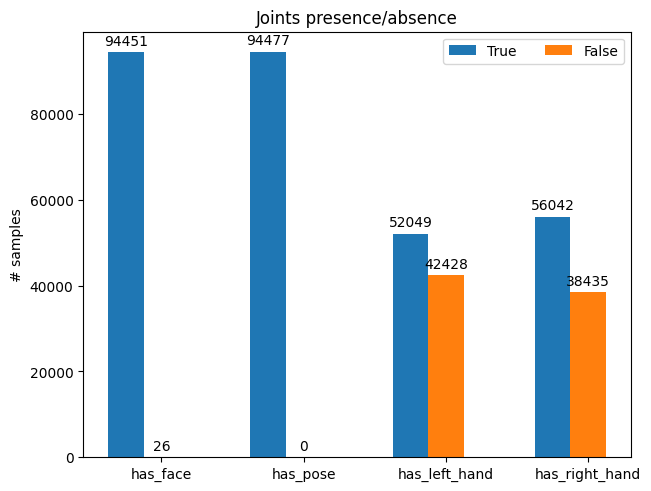

In [292]:
# Plot presence absence of joints

species = ('has_face', 'has_pose', 'has_left_hand', 'has_right_hand')
face_counts = data.has_face.value_counts()
pose_counts = data.has_pose.value_counts()
rhand_counts = data.has_right_hand.value_counts()
lhand_counts = data.has_left_hand.value_counts()
penguin_means = {
    'True': (face_counts.values[0], pose_counts[0], lhand_counts.values[0], rhand_counts.values[0]),
    'False': (face_counts.values[1], 0, lhand_counts.values[1], rhand_counts.values[1]),
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained')

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('# samples')
ax.set_title('Joints presence/absence')
ax.set_xticks(x + width, species)
ax.legend(loc='upper right', ncols=3)

plt.show()

In [317]:
# Porcentage missing values of joints

def pct_missing(row):
    seq = read_landmark_data_by_path(row.path)
    row['pct_missing_left_hand'] = seq[seq.type == 'left_hand'][['x','y','z']].isnull().sum().sum() / seq[seq.type == 'left_hand'][['x','y','z']].values.size 
    row['pct_missing_right_hand'] = seq[seq.type == 'right_hand'][['x','y','z']].isnull().sum().sum() / seq[seq.type == 'right_hand'][['x','y','z']].values.size 
    row['pct_missing_pose'] = seq[seq.type == 'pose'][['x','y','z']].isnull().sum().sum() / seq[seq.type == 'pose'][['x','y','z']].values.size
    row['pct_missing_face'] = seq[seq.type == 'face'][['x','y','z']].isnull().sum().sum() / seq[seq.type == 'face'][['x','y','z']].values.size
    
    return row

# data = data.progress_apply(pct_missing, axis=1) # Takes 40:38 mins
data.to_csv('edata.csv')

In [322]:
data.query('has_face == True & has_left_hand == True & has_pose == True & has_right_hand == True')[[
    'pct_missing_right_hand', 'pct_missing_face', 'pct_missing_pose', 'pct_missing_left_hand'
]]


,pct_missing_right_hand,pct_missing_face,pct_missing_pose,pct_missing_left_hand
sequence_id,,,,
100137027,0.846154,0.0,0.0,0.923077
1002284514,0.853659,0.0,0.0,0.804878
1003007869,0.645161,0.0,0.0,0.935484
1003109377,0.913043,0.0,0.0,0.130435
1004285193,0.750000,0.0,0.0,0.800000
...,...,...,...,...
996926844,0.756098,0.0,0.0,0.463415
997106129,0.357143,0.0,0.0,0.785714
997426970,0.804348,0.0,0.0,0.652174


In [349]:
# General statistics: min, max, mean and std values for missing joints
print('Face')
print(data.query('has_face == True').pct_missing_face.min(), data.query('has_face == True').pct_missing_face.max(), data.query('has_face == True').pct_missing_face.mean(), data.query('has_face == True').pct_missing_face.std())

print('\nPose')
print(data.query('has_pose == True').pct_missing_pose.min(), data.query('has_pose == True').pct_missing_pose.max(), data.query('has_pose == True').pct_missing_pose.mean(), data.query('has_pose == True').pct_missing_pose.std())

print('\nRight hand')
print(data.query('has_right_hand == True').pct_missing_right_hand.min(), data.query('has_right_hand == True').pct_missing_right_hand.max(), data.query('has_right_hand == True').pct_missing_right_hand.mean(), data.query('has_right_hand == True').pct_missing_right_hand.std())

print('\nLeft hand')
print(data.query('has_left_hand == True').pct_missing_left_hand.min(), data.query('has_left_hand == True').pct_missing_left_hand.max(), data.query('has_left_hand == True').pct_missing_left_hand.mean(), data.query('has_left_hand == True').pct_missing_left_hand.std())

Face
0.0 0.9411764705882353 0.0071407649234757654 0.049344268034966894

Pose
0.0 0.0 0.0 0.0

Right hand
0.0 0.9968553459119497 0.3563392897354605 0.29448979511105206

Left hand
0.0 0.9976303317535545 0.38142575219085184 0.30355934204709645


In [443]:
# Sequences that have information in all frames per joint

print('Face')
print(len(data.query('has_face == True & pct_missing_face == 0.0')))

print('\nPose')
print(len(data.query('has_pose == True & pct_missing_pose == 0.0')))

print('\nRight hand')
print(len(data.query('has_right_hand == True & pct_missing_right_hand == 0.0')))

print('\nLeft hand')
print(len(data.query('has_left_hand == True & pct_missing_left_hand == 0.0')))

print('\nEverything complete')
print(len(data.query('has_face == True & pct_missing_face == 0.0 & has_pose == True & pct_missing_pose == 0.0 & has_right_hand == True & pct_missing_right_hand == 0.0 & has_left_hand == True & pct_missing_left_hand == 0.0')))

Face
90041

Pose
94477

Right hand
11452

Left hand
6929

Everything complete
0


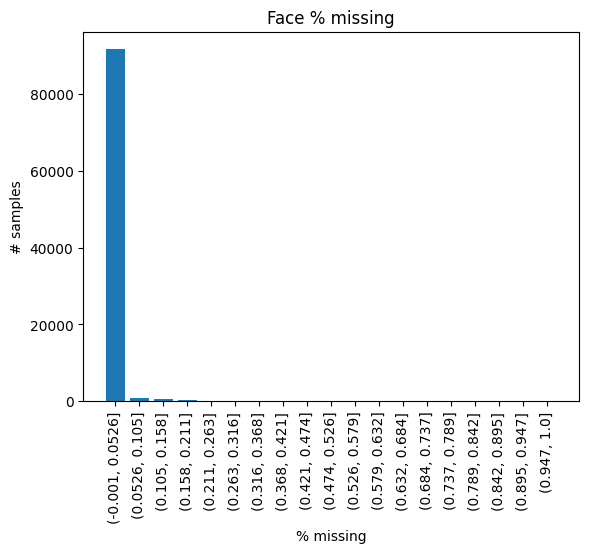

In [444]:
bins = np.linspace(0, 1, 20)
to_plot = pd.cut(data.query('has_face == True').pct_missing_face, bins, include_lowest=True).value_counts().sort_index()
plt.bar(to_plot.index.astype(str), to_plot.values)
plt.xticks(rotation=90)
plt.title('Face % missing')
plt.xlabel('% missing')
plt.ylabel('# samples')
plt.show()

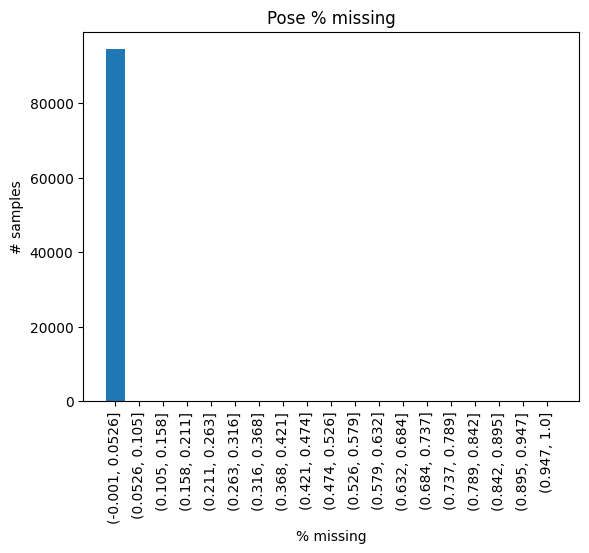

In [445]:
bins = np.linspace(0, 1, 20)
to_plot = pd.cut(data.query('has_pose == True').pct_missing_pose, bins, include_lowest=True).value_counts().sort_index()
plt.bar(to_plot.index.astype(str), to_plot.values)
plt.xticks(rotation=90)
plt.title('Pose % missing')
plt.xlabel('% missing')
plt.ylabel('# samples')
plt.show()

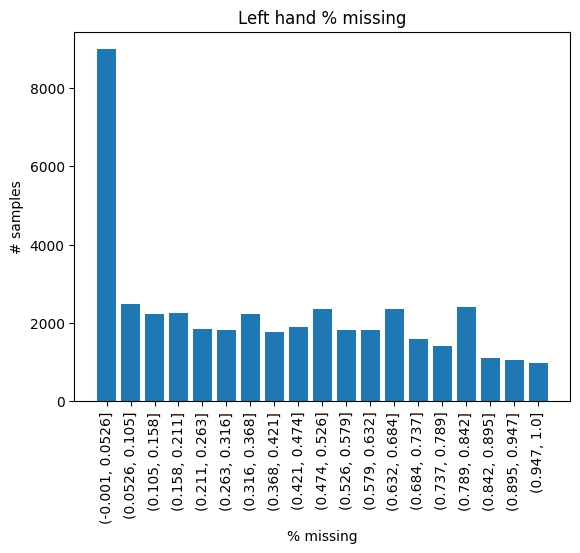

In [446]:
bins = np.linspace(0, 1, 20)
to_plot = pd.cut(data.query('has_left_hand == True').pct_missing_left_hand, bins, include_lowest=True).value_counts().sort_index()
plt.bar(to_plot.index.astype(str), to_plot.values)
plt.xticks(rotation=90)
plt.title('Left hand % missing')
plt.xlabel('% missing')
plt.ylabel('# samples')
plt.show()

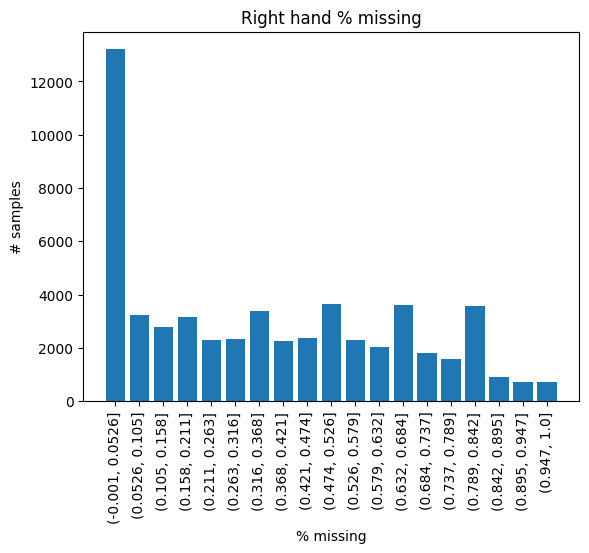

In [447]:
bins = np.linspace(0, 1, 20)
to_plot = pd.cut(data.query('has_right_hand == True').pct_missing_right_hand, bins, include_lowest=True).value_counts().sort_index()
plt.bar(to_plot.index.astype(str), to_plot.values)
plt.xticks(rotation=90)
plt.title('Right hand % missing')
plt.xlabel('% missing')
plt.ylabel('# samples')
plt.show()

# Are there signs that use either one of the hands?

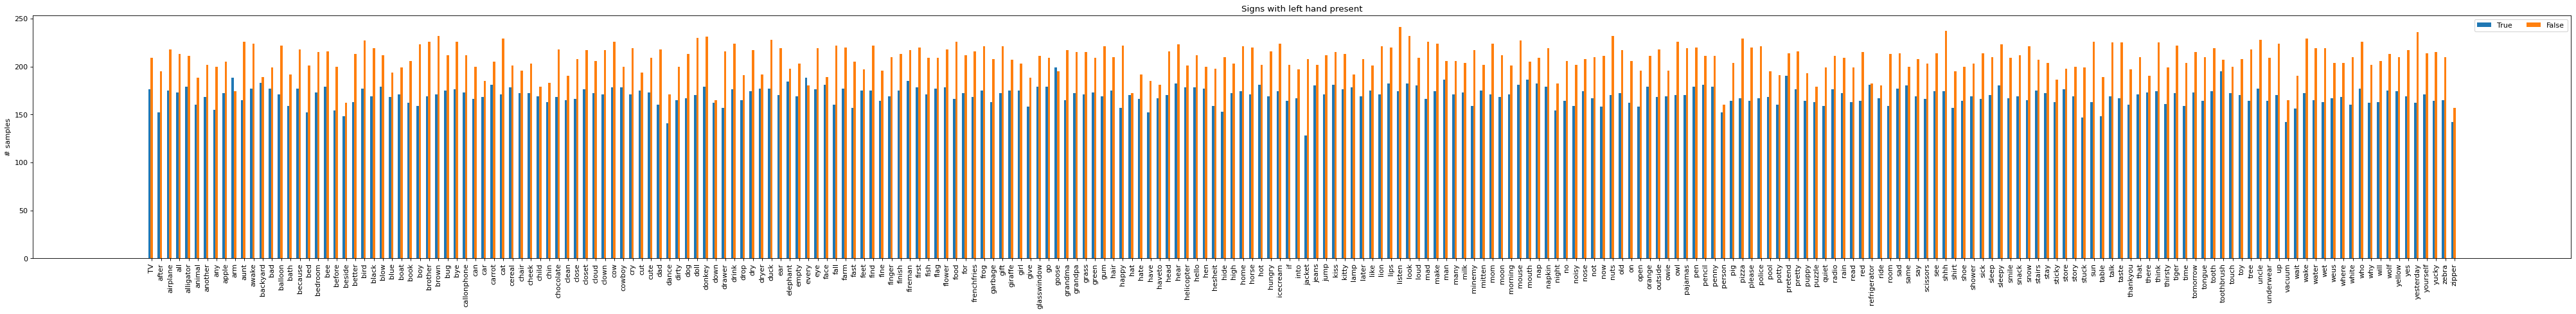

In [519]:
# Plot presence absence of joints

to_plot_left = data.groupby('sign')[['has_left_hand']].value_counts().reset_index().rename(columns={0:'c'})
to_plot_right = data.groupby('sign')[['has_right_hand']].value_counts().reset_index().rename(columns={0:'c'})

species = to_plot.sign.unique()

penguin_means = {
    'True': tuple(to_plot.query('sign == @s & has_left_hand == True')['c'].values[0] for s in species),
    'False': tuple(to_plot.query('sign == @s & has_left_hand == False')['c'].values[0] for s in species),
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(50, 6), dpi=80)

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('# samples')
ax.set_title('Signs with left hand present')
ax.set_xticks(x + width, species, rotation=90)
ax.legend(loc='upper right', ncols=3)

plt.show()

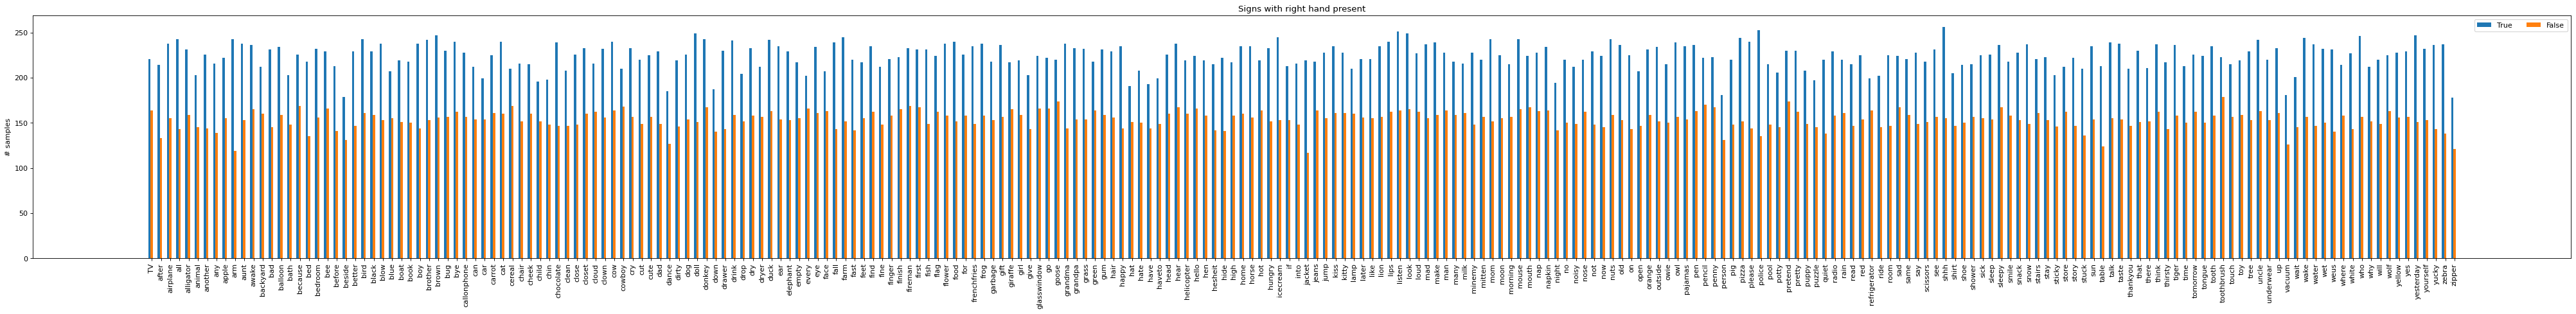

In [520]:
to_plot = data.groupby('sign')[['has_right_hand']].value_counts().reset_index().rename(columns={0:'c'})
species = to_plot.sign.unique()

penguin_means = {
    'True': tuple(to_plot.query('sign == @s & has_right_hand == True')['c'].values[0] for s in species),
    'False': tuple(to_plot.query('sign == @s & has_right_hand == False')['c'].values[0] for s in species),
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(50, 6), dpi=80)

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('# samples')
ax.set_title('Signs with right hand present')
ax.set_xticks(x + width, species, rotation=90)
ax.legend(loc='upper right', ncols=3)

plt.show()

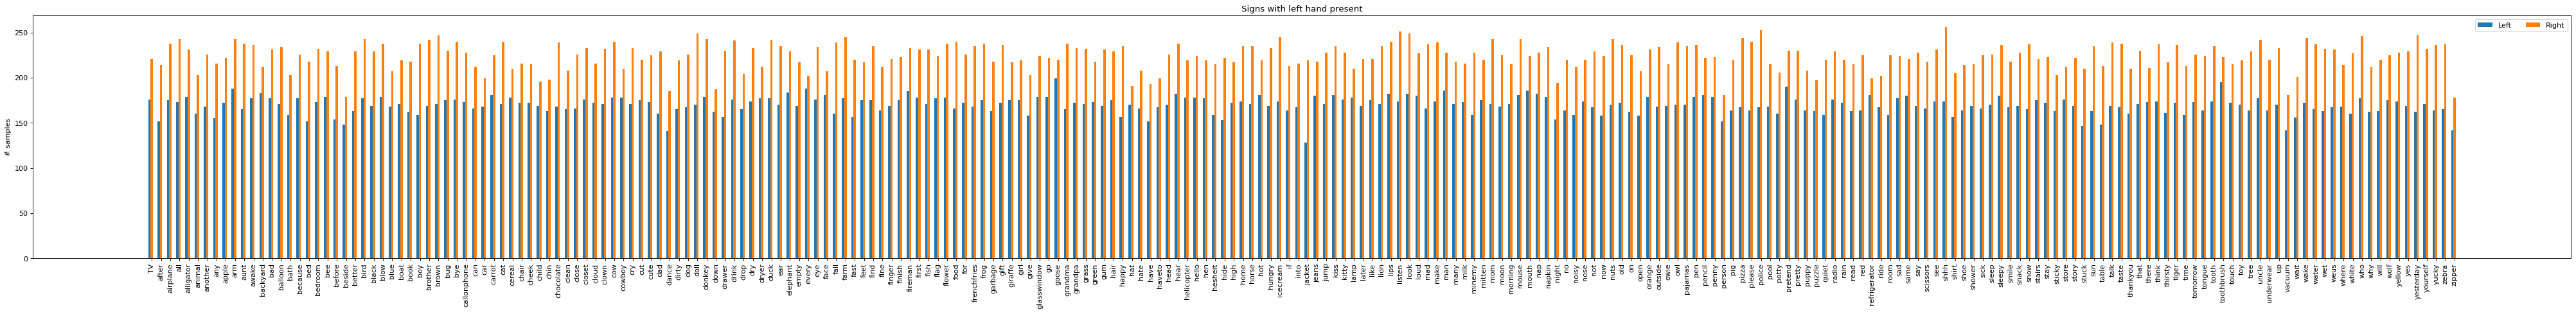

In [531]:
# Plot presence absence of joints

to_plot_left = data.groupby('sign')[['has_left_hand']].value_counts().reset_index().rename(columns={0:'c'})
to_plot_right = data.groupby('sign')[['has_right_hand']].value_counts().reset_index().rename(columns={0:'c'})

species = to_plot.sign.unique()

penguin_means = {
    'Left': tuple(to_plot_left.query('sign == @s & has_left_hand == True')['c'].values[0] for s in species),
    'Right': tuple(to_plot_right.query('sign == @s & has_right_hand == True')['c'].values[0] for s in species),
}

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(50, 6), dpi=80)

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    # ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('# samples')
ax.set_title('Signs with left hand present')
ax.set_xticks(x + width, species, rotation=90)
ax.legend(loc='upper right', ncols=3)

plt.show()

In [555]:
idxs = [489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,0,37,39,40,185,61,146,91,181,84,17,314,405,321,375,291,409,270,269,267,13,82,81,80,191,78,95,88,178,87,14,317,402,318,324,308,415,310,311,312,33,7,163,144,145,153,154,155,133,173,157,158,159,160,161,246,362,382,380,381,374,373,390,249,263,466,388,387,386,385,384,398,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542]

In [572]:
FACE_LIPS = [0, 37, 39, 40, 185, 61, 146, 91, 181, 84, 17, 314, 405, 321, 375,
             291, 409, 270, 269, 267, 13, 82, 81, 80, 191, 78, 95, 88, 178, 87,
             14, 317, 402, 318, 324, 308, 415, 310, 311, 312]
FACE_REYE = [33, 7, 163, 144, 145, 153, 154, 155, 133, 173, 157, 158, 159, 160, 
             161, 246]
FACE_LEYE = [362, 382, 380, 381, 374, 373, 390, 249, 263, 466, 388, 387, 386,
             385, 384, 398]

comb = FACE_LIPS + FACE_REYE + FACE_LEYE

In [573]:
np.isin(seq.iloc[idxs].query('type == "face"').landmark_index.unique(), comb)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True])

In [570]:
seq.iloc[idxs].query('type == "face"').landmark_index.unique()

array([  0,  37,  39,  40, 185,  61, 146,  91, 181,  84,  17, 314, 405,
       321, 375, 291, 409, 270, 269, 267,  13,  82,  81,  80, 191,  78,
        95,  88, 178,  87,  14, 317, 402, 318, 324, 308, 415, 310, 311,
       312,  33,   7, 163, 144, 145, 153, 154, 155, 133, 173, 157, 158,
       159, 160, 161, 246, 362, 382, 380, 381, 374, 373, 390, 249, 263,
       466, 388, 387, 386, 385, 384, 398], dtype=int16)

In [543]:
# Copy generated data to data/preprocessed folder

from shutil import copyfile
data.to_csv('edata.csv')
copyfile('edata.csv', Cfg.OUTPUT_ROOT / 'edata.csv')

PosixPath('../data/preprocessed/edata.csv')